# Final Dataset Compilation

We wish to take external data to use for our ML model. We take this external data from the world bank since our loan documents are already from the World Bank:

#### World Bank:
https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators

https://info.worldbank.org/governance/wgi/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

#### Import our files downloaded from the world bank. Also imports our loan document to merge with our own loan data.

In [2]:
# Access to electricity (% of population)
elec = pd.read_csv("AccessToElec.csv")
elec.rename(columns={'Country Name': 'Country'}, inplace=True)
elec.set_index('Country', inplace=True)
elec.index = elec.index.str.lower()

# GDP per Capita (Current international $)
gdp = pd.read_csv("GDPperCapWB.csv")
gdp.rename(columns={'Country Name': 'Country'}, inplace=True)
gdp.set_index('Country', inplace=True)
gdp.index = gdp.index.str.lower()

# Literacy rates (% adults)
lit = pd.read_csv("Literacy.csv")
lit.rename(columns={'Country Name': 'Country'}, inplace=True)
lit.set_index('Country', inplace=True)
lit.index = lit.index.str.lower()

# Gini-coeff
gini = pd.read_csv("GiniCoeff.csv")
gini.rename(columns={'Country Name': 'Country'}, inplace=True)
gini.set_index('Country', inplace=True)
gini.index = gini.index.str.lower()

# Stability - Political stableness AND safety from violence/terrorism
# Actually was done separately at first, so already have the data here.
# Consoldated code into one notebook though! May need to check the StabilityRaw.csv and ensure "country_dict"
# Was properly changed for the countries if using code as written here.

## Code used in previous notebook to obtain results:
# stab = pd.read_csv("StabilityRaw.csv")
# stab.rename(columns={'Country Name': 'Country'}, inplace=True)
# stab.set_index('Country', inplace=True)
# stab.index = stab.index.str.lower()
stab = pd.read_csv("Stability.csv")

## Used to identify countries needing to be replaced
# for cntry in loan.Country.value_counts().index:
#     print(cntry, ": ", sum(lit.index == cntry))

# Countries that need to be renamed
# This is fixed manually in csv files
country_dict = {"venezuela, rb": "venezuela",
                "slovak republic": "slovakia", "syrian arab republic": "syria", "russian federation": "russia",
               "iran, islamic rep.": "iran", "egypt, arab rep.": "egypt", "north macedonia": "macedonia",
               "St. Lucia": "saint lucia", "Lao PDR": "laos", "Eswatini": "swaziland", "Côte d'Ivoire": "cote d'ivoire"}

# Import loan amount document
loan = pd.read_csv("Final_loan_amount.csv")
loan = loan[loan.max_country != 'united states']
loan = loan[loan.max_country != 'None']
loan.rename(columns={'max_country': 'Country', 'Unnamed: 0': 'Filename', 'year': 'Year', 'world_region': 'Region'}, inplace=True)
loan.set_index('Filename', inplace=True)

# Drops all entries that aren't needed... Makes things easier to read...
for cntry in elec.index:
    if sum(loan.Country.value_counts().index == cntry) == 0:
        elec.drop(labels=cntry, inplace=True)
        gdp.drop(labels=cntry, inplace=True)
        lit.drop(labels=cntry, inplace=True)
        gini.drop(labels=cntry, inplace=True)
#         stab.drop(labels=cntry, inplace=True)

In [3]:
# Convert strings to numbers
for col in elec.columns:
    elec[col] = pd.to_numeric(elec[col], errors='coerce')

for col in gdp.columns:
    gdp[col] = pd.to_numeric(gdp[col], errors='coerce')
    
for col in lit.columns:
    lit[col] = pd.to_numeric(lit[col], errors='coerce')
    
for col in gini.columns:
    gini[col] = pd.to_numeric(gini[col], errors='coerce')
    
# for col in stab.columns:
#     stab[col] = pd.to_numeric(stab[col], errors='coerce')

In [4]:
# #Convert dataframes from wide to long
elec = elec.unstack().swaplevel().to_frame().reset_index()
elec.columns = ['Country', 'Year', 'Elec']

gdp = gdp.unstack().swaplevel().to_frame().reset_index()
gdp.columns = ['Country', 'Year', 'GDPpC']

lit = lit.unstack().swaplevel().to_frame().reset_index()
lit.columns = ['Country', 'Year', 'Lit']

gini = gini.unstack().swaplevel().to_frame().reset_index()
gini.columns = ['Country', 'Year', 'Gini']

# stab = stab.unstack().swaplevel().to_frame().reset_index()
# stab.columns = ['Country', 'Year', 'Gini']

In [5]:
# Convert years to integers
elec['Year'] = elec['Year'].astype(int)
gdp['Year'] = gdp['Year'].astype(int)
lit['Year'] = lit['Year'].astype(int)
gini['Year'] = gini['Year'].astype(int)
# stab['Year'] = stab['Year'].astype(int)

#### Merge dataframes together

In [6]:
# Combine dataframes into one
step_df1 = pd.merge(elec, gdp, on=['Country', 'Year'], how='left')
step_df2 = pd.merge(step_df1, lit, on=['Country', 'Year'], how='left')
step_df3 = pd.merge(step_df2, gini, on=['Country', 'Year'], how='left')
step_df4 = pd.merge(step_df3, stab, on=['Country', 'Year'], how='left')

# Include all of the data based on Country and Year
Final_df = pd.merge(loan, step_df4, on=['Country', 'Year'], how='left')

#### Impute values with KNN:

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer
    
This method was chosen since it would more accurately look at "nearby" data to estimate the values that are missing. (This is opposed to taking the mean or median for the entire dataset, which it may not fully represent the behavior of the data.)

In [7]:
Final_df[['Elec', 'GDPpC', 'Lit', 'Gini', 'Stability']] = KNNImputer(n_neighbors=5).fit_transform(Final_df[['Elec', 'GDPpC', 'Lit', 'Gini', 'Stability']])

#### Check imputation

In [8]:
Final_df

,Year,loan_amount,Country,Region,Elec,GDPpC,Lit,Gini,Stability
0,1990,1.800000e+07,poland,eastern europe,100.000000,6170.249054,90.032054,39.30,-0.418
1,1990,3.290000e+08,indonesia,asia (ex. near east),100.000000,3082.082407,81.519852,31.20,-0.308
2,1990,3.500000e+08,peru,latin amer. & carib,53.247423,3361.406815,72.116540,38.06,-0.102
3,1990,1.100000e+08,algeria,northern africa,97.200000,6916.495704,99.704750,39.50,-0.490
4,1990,2.500000e+07,india,asia (ex. near east),16.958274,1201.668486,48.222069,42.88,-1.024
...,...,...,...,...,...,...,...,...,...
2870,2019,4.000000e+08,india,asia (ex. near east),97.815285,6994.025149,97.218462,32.68,-0.770
2871,2019,1.399343e+08,macedonia,eastern europe,100.000000,17583.379370,93.468790,38.80,0.000
2872,2019,2.500000e+06,colombia,latin amer. & carib,99.766273,15630.075210,95.249268,51.30,-0.950
2873,2019,2.798686e+07,oman,near east,100.000000,28448.858780,95.660716,39.36,0.590


#### Check imputation for a given country to make sure certain rates are reasonable and are constant for each year

In [12]:
Final_df[Final_df.Country == 'china']

,Year,loan_amount,Country,Region,Elec,GDPpC,Lit,Gini,Stability
15,1990,7.500000e+07,china,asia (ex. near east),32.013373,982.500870,77.785057,32.20,-0.286
100,1990,7.500000e+07,china,asia (ex. near east),32.013373,982.500870,77.785057,32.20,-0.286
140,1991,4.500000e+07,china,asia (ex. near east),17.319895,1094.771431,60.124442,43.70,-0.286
151,1991,5.000000e+07,china,asia (ex. near east),17.319895,1094.771431,60.124442,43.70,-0.286
154,1991,7.940000e+07,china,asia (ex. near east),17.319895,1094.771431,60.124442,43.70,-0.286
...,...,...,...,...,...,...,...,...,...
2789,2014,3.000000e+08,china,asia (ex. near east),100.000000,12549.771830,91.347806,39.20,-0.520
2795,2014,1.500000e+08,china,asia (ex. near east),100.000000,12549.771830,91.347806,39.20,-0.520
2804,2015,1.500000e+08,china,asia (ex. near east),100.000000,12978.768910,92.951311,38.60,-0.550
2814,2016,3.000000e+08,china,asia (ex. near east),100.000000,13572.619990,98.531644,38.50,-0.500


#### Test some random plots to see if dataset seems reasonable

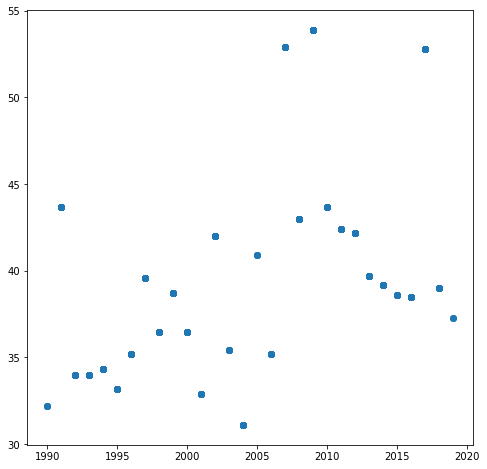

In [16]:
plt.figure(figsize=(8,8))

plt.scatter(Final_df[Final_df.Country == 'china'].Year, Final_df[Final_df.Country == 'china'].Gini)

plt.show()

In [10]:
Final_df.to_csv('Finalized_Dataset.csv')